## Group Members

***Rahul Singh - 220940128024***

***Sayyed Mujjmil - 220940128029***

***Mohit Bulani - 220940128015***

***Shanki Shekhar - 220940128031***

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU') 

# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
### Global  parameters and Hyperparamaters

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run
ALPHA = 0.01
BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 190
IMG_WIDTH = 190

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 10 # if performance does not improve stop

# oss=('categorical_crossentropy', opt)

LR_PATIENCE = 5 # if performace is not improving reduce alpha

LR_FACTOR = 0.9 # rate of reduction of alpha


### Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
flower_directory = "/content/drive/MyDrive/Project group/flower_photos"
flower_directory

'/content/drive/MyDrive/Project group/flower_photos'

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(flower_directory,
                                                              validation_split=TEST_SIZE,
                                                              subset="training",
                                                              seed=RANDOM_STATE,
                                                              image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(flower_directory,
                                                              validation_split=TEST_SIZE,
                                                              subset="validation",
                                                              seed=RANDOM_STATE,
                                                              image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 2178 files belonging to 6 classes.
Using 1743 files for training.
Found 2178 files belonging to 6 classes.
Using 435 files for validation.


In [8]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  6 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips', 'weights']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


In [9]:
def fn_plot_lable(train,title,color=None):

    train.take(count=-1)
    lables_train = []
    for (feat,label) in train.take(count=-1):
        for l in label:
            lables_train.append(l.numpy())

    # lables_train = [l.numpy() for l in label for (feat,label) in train.take(count=-1)]

    train_lab_dict = {}
    for i in set(lables_train):
        train_lab_dict[i] = lables_train.count(i)



    
        
    plt.bar(train_lab_dict.keys(),height=train_lab_dict.values(),zorder=3,color=color)
    plt.xlabel("Labels")
    plt.ylabel("Label Count")
    plt.title(str(title))
    plt.grid()
#     plt.legend()

In [10]:
# plt.figure(figsize=(15,4))
# plt.subplot(121)
# fn_plot_lable(train_ds,"Train Data")
# plt.subplot(122)
# fn_plot_lable(test_ds,"Test Data",color="Maroon")

# plt.show()

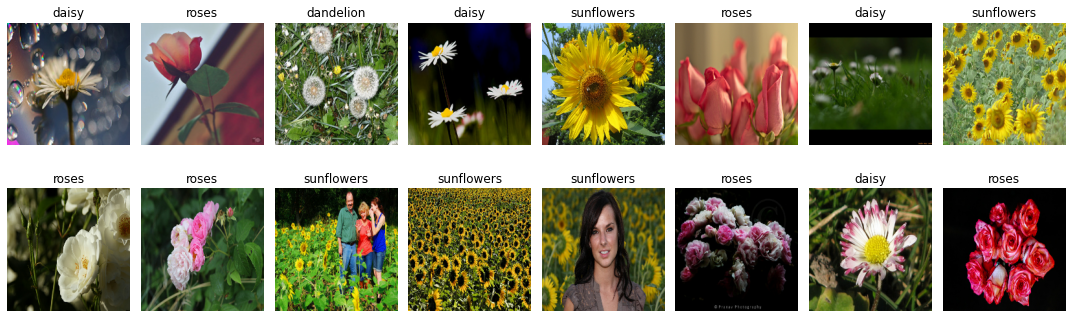

In [11]:
plt.figure(figsize=(15,5))
for image,label in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(2,8,i+1)
#         print(image[i].numpy().shape)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[label[i]])
        plt.axis(False)
        plt.grid(False)
    plt.tight_layout()
    plt.show()

In [12]:
#initialising input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### RandomZoom

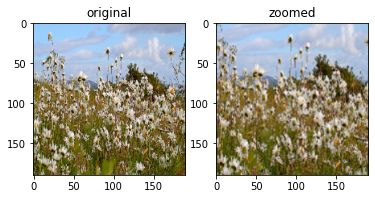

In [14]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),width_factor=(-0.2,-0.2))

plt.figure()
img_num = 3

for images, labels in train_ds.take(1):
    out_images = layer(images)
    plt.subplot(1,2,1)
    plt.title('original')
    plt.imshow(images[img_num].numpy().astype('uint8'))
    plt.subplot(1,2,2)
    plt.title('zoomed')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
    
plt.show()

#### Nodel Building:

In [15]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
DROP_RATE = 0.15

In [17]:
# Model function fr DROP RATE =0.15 and  ACTIVATION = 'RELU'

In [18]:

def build_model():
    model = tf.keras.models.Sequential()
    
    #Rescaling Layer
    model.add(tf.keras.layers.Rescaling(1./255.))
    
    #Data Augumentation Layers
    model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode= FILL_MODE, seed= RANDOM_STATE)) # (190,190,3)
    
    model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed= RANDOM_STATE)) # (190,190,3)
    
    model.add(tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.3),width_factor=(-0.2, 0.3),seed= RANDOM_STATE)) # (190,190,3)
    
    model.add(tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2),width_factor=(0.2, 0.3),seed= RANDOM_STATE))   # (190,190,3) 
    
    #CONvolution -- BatchNorm -- Activation -- Dropout -- Maxpool Layers 1
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))  # (190,190,64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(rate=0.15 , seed=RANDOM_STATE))

    # maxpool -1
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) #95X95

    #CONvolution -- BatchNorm -- Activation -- Dropout -- Maxpool Layers 2
    model.add(tf.keras.layers.Conv2D(128, (3, 3),padding='same'))  # (95,95,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(rate=0.15,seed=RANDOM_STATE))
    # maxpool -2
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #47 x 47
    
    #CONvolution -- BatchNorm -- Activation -- Dropout -- Maxpool Layers 3
    model.add(tf.keras.layers.Conv2D(256, (3, 3),padding='same'))  # (47X47x256)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.15,seed=RANDOM_STATE))

    # maxpool -3
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #23X23
    
    #CONvolution -- BatchNorm -- Activation -- Dropout -- Maxpool Layers 4
    model.add(tf.keras.layers.Conv2D(512, (3, 3),padding='same')) #(23,x23x512)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.15,seed=RANDOM_STATE))


    # maxpool -4
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #11 x 11
    
    #CONvolution -- BatchNorm -- Activation -- Dropout -- Maxpool Layers 5
    model.add(tf.keras.layers.Conv2D(1024, (3, 3),padding='same'))  # (11x11x1024
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.15,seed=RANDOM_STATE))


    # maxpool -5
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))  #5 x 5


    

    # Dense Layers
    #Convolution  Layer 6
    model.add(tf.keras.layers.Conv2D(2048, (3, 3), activation='relu')) # (3 X 3 x2048)
#_________________________________________________________________________________________________________________________________________________________________________   
 
    #Flattening Layer
    model.add(tf.keras.layers.Flatten())

    #Dense Layers:
    model.add(tf.keras.layers.Dense(1024, activation='relu'))

    # Dropout Layer
    #model.add(tf.keras.layers.Dropout(0.15,seed=RANDOM_STATE))

    model.add(tf.keras.layers.Dense(256, activation='relu'))


    model.add(tf.keras.layers.Dense(128, activation='relu'))

    model.add(tf.keras.layers.Dense(64, activation='relu'))

    model.add(tf.keras.layers.Dense(5))
    
    return model

In [19]:
model = build_model()
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)




modelDir = '/home/dai/Desktop/DeepNeural Network/models'
subDir = '/home/dai/Desktop/DeepNeural Network/Input_Data/input-20221210T065619Z-001'


checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_l2')

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)



In [20]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [22]:
hist = model.fit(train_ds,validation_data=test_ds,batch_size = BATCH_SIZE,epochs = EPOCHS,callbacks = [early_callback,model_callback])

Epoch 1/100


109/109 [==============================] - ETA: 0s - loss: 2.5137 - accuracy: 0.5123
Epoch 1: val_loss improved from inf to 1.41521, saving model to /home/dai/Desktop/DeepNeural Network/Input_Data/input-20221210T065619Z-001/weights_l2
109/109 [==============================] - 39s 251ms/step - loss: 2.5137 - accuracy: 0.5123 - val_loss: 1.4152 - val_accuracy: 0.3195
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.9793 - accuracy: 0.6540
Epoch 2: val_loss improved from 1.41521 to 1.39515, saving model to /home/dai/Desktop/DeepNeural Network/Input_Data/input-20221210T065619Z-001/weights_l2
109/109 [==============================] - 21s 196ms/step - loss: 0.9793 - accuracy: 0.6540 - val_loss: 1.3952 - val_accuracy: 0.3218
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 0.9033 - accuracy: 0.6787
Epoch 3: val_loss did not improve from 1.39515
109/109 [==============================] - 19s 171ms/step - loss: 0.9033 - accuracy: 0.6787 - val_loss

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 190, 190, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 190, 190, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 190, 190, 3)       0         
                                                                 
 random_translation (RandomT  (None, 190, 190, 3)      0         
 ranslation)                                                     
                                                                 
 random_zoom_1 (RandomZoom)  (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 190, 190, 64)      1

In [24]:
hist_df = pd.DataFrame(hist.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.513727,0.512335,1.415212,0.319540
1,0.979310,0.654045,1.395151,0.321839
2,0.903302,0.678715,1.426359,0.326437
3,0.878312,0.686747,1.284179,0.496552
4,0.863990,0.677567,1.167800,0.666667


In [25]:
hist_df['val_loss'].min(),hist_df['val_accuracy'].max()

(0.6238325238227844, 0.8160919547080994)

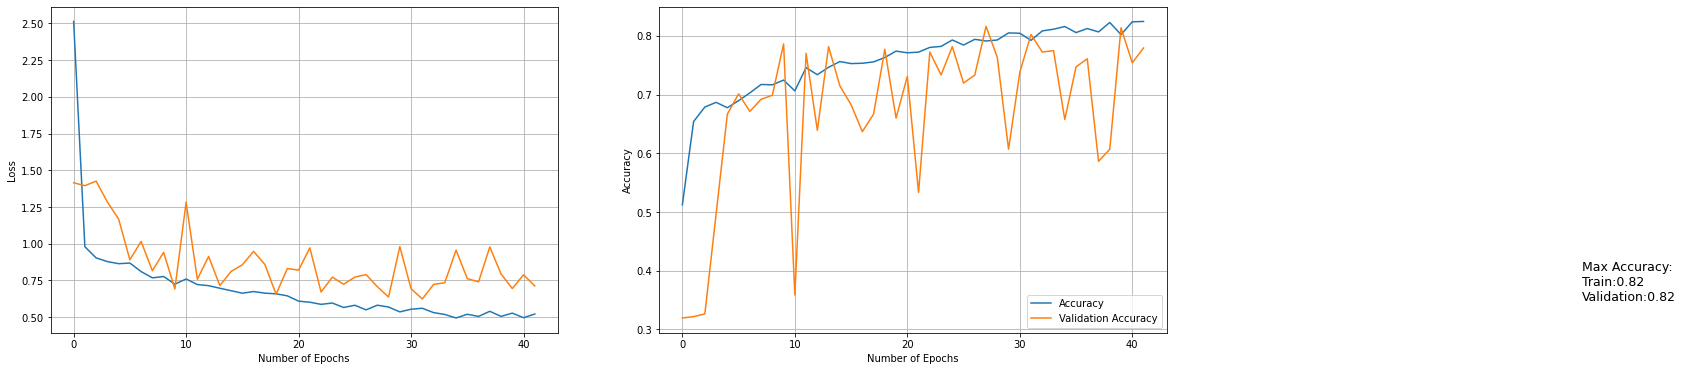

In [26]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(hist_df["loss"],label="Loss",zorder=3)
plt.plot(hist_df["val_loss"],label="Validation Loss",zorder=3)
plt.text(75,1.15,f"Min Loss:\nTrain:{round(hist_df['loss'].min(),2)}\nValidation:{round(hist_df['val_loss'].min(),2)}",fontsize=12.5)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
#plt.legend()

plt.subplot(122)
plt.plot(hist_df["accuracy"],label="Accuracy",zorder=3)
plt.plot(hist_df["val_accuracy"],label="Validation Accuracy",zorder=3)
plt.text(80,0.35,f"Max Accuracy:\nTrain:{round(hist_df['accuracy'].max(),2)}\nValidation:{round(hist_df['val_accuracy'].max(),2)}",fontsize=12.5)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.show()

In [28]:
# model.evaluate (test_ds, verbose=2)

### Model Evaluation:

In [29]:
test_loss,test_accuracy = model.evaluate(test_ds,verbose=1)
print(test_loss,test_accuracy)

28/28 [==============================] - 1s 31ms/step - loss: 0.6238 - accuracy: 0.8023
0.6238325238227844 0.8022988438606262


In [30]:
y_hat = model.predict(test_ds)

y_test = tf.concat([y for x,y in test_ds],axis=0).numpy()

y_pred = y_hat.argmax(axis=1)
print(accuracy_score(y_test,y_pred))

28/28 [==============================] - 1s 27ms/step
0.8022988505747126


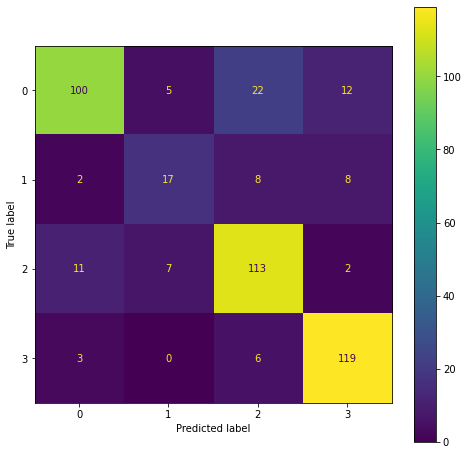

In [32]:
fig,ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax)
plt.show()